In [1]:
#importing คำสั่งที่ต้องใช้
from skimage.io import imread
from skimage.transform import resize


import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [5]:
img_paths = pd.read_csv('img_paths.csv')
img_paths.head()

,img_path,target
0,original_images\0\o1.jpg,0
1,original_images\0\o10.jpg,0
2,original_images\0\o100.jpg,0
3,original_images\0\o1000.jpg,0
4,original_images\0\o1001.jpg,0


In [6]:
# add labels

labelTr = []
for label in img_paths['target']:
    labelTr.append(label)

In [7]:
len(labelTr)

250

In [8]:
# นำรูปจากชุดข้อมูลมา read และ resize และแปลงเป็น gray scale

import cv2
import numpy
import glob

read_images = []

for image in img_paths['img_path']:
    image = cv2.imread(image)
    image = cv2.resize(image, (180,180), interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    read_images.append(image)

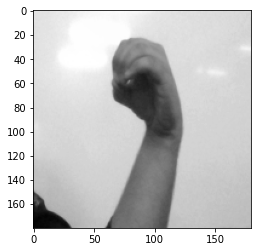

In [9]:
plt.imshow(read_images[1], 'gray')

In [10]:
# นำรูปที่ได้หลังจากการ format มาสกัด hog

from skimage.feature import hog

# สร้าง list ว่างมาเพื่อเก็บรูปหลังการสกัด และ feature vector
hog_images = []
feature_hog = []

# สกัด hog feature
for image in read_images:
    fd,hog_image = hog(image, 
                       orientations=8,
                       cells_per_block=(2, 2),
                       pixels_per_cell=(8,8),
                       visualize=True)
    
    hog_images.append(hog_image)
    feature_hog.append(fd)

# reshape ขนาดรูปภาพ เพื่อจะได้นำไป concat กับ feature อีกหนึ่งตัวได้ เพราะ ถ้าขนาดไม่เท่ากัน จะไม่สามารถ concat กันได้
feature_hog = np.array(feature_hog).reshape(250,-1)

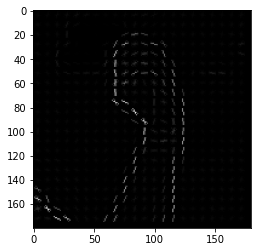

In [11]:
# ภาพตัวอย่างของการสกัด feature
plt.imshow(hog_images[1], 'gray')

In [12]:
feature_hog

array([[0.04183138, 0.03485182, 0.05608478, ..., 0.11324388, 0.23956718,
        0.        ],
       [0.24976643, 0.07767068, 0.15954274, ..., 0.08773842, 0.24384052,
        0.04478445],
       [0.25253138, 0.09047009, 0.25253138, ..., 0.02315982, 0.23941415,
        0.03275293],
       ...,
       [0.24088597, 0.05343021, 0.24544226, ..., 0.09661722, 0.26554016,
        0.21570797],
       [0.26931286, 0.0995096 , 0.26931286, ..., 0.14212215, 0.22087096,
        0.12085194],
       [0.39508671, 0.39508671, 0.29921694, ..., 0.00499925, 0.04121836,
        0.01628817]])

In [13]:
# การทำงานคือ ค้นหาจุดมุมของภาพโดยมองผ่านหน้าต่างเล็กที่กำหนดขึ้นภายในจะเป็นเส้นขอบของรูป จากนั้นให้เลื่อนหน้าต่างเล็กๆที่ได้กำหนดขึ้น
# ไปในทิศทางต่างๆตามเส้นเมื่อพบกับการเปลี่ยนแปลงเส้นทางเป็นอย่างมาก หรือ เกิดการหักเหของเส้นมาก จะถือว่าจุดนั้นเป็นจุดมุม

def shi_tomasi(image):
    
    # ต้องแปลงเป็นรูป gray ก่อน
    # แปลงเป็น gray เห็นความแตกต่างระหว่างขาว ดำมากขึ้น เห็นการเปลี่ยนแปลงของเส้น ของขอบมากขึ้น จากภาพสี
    # goodfeaturetotrack (gray_image, max number of corners, quality levels, minimum euclidean distance between corners)
    # 0.01 is the minimum quality level below which the corners are rejected
    # 10 is the minimum euclidean distance between two corners
    
    corners_img = cv2.goodFeaturesToTrack(image,20,0.01,10)
    
    # convert corners values to integer
    # So that we will be able to draw circles on them
    corners_img = np.int0(corners_img)
    
    # draw red color circles on all corners
    for corners in corners_img:
        x,y = corners.ravel()
        
        # 255 คือสีของจุด
        cv2.circle(image,(x,y),3,(255, 0, 0),-1)
        
    return image

In [14]:
# สร้าง list ว่าง เพื่อเก็บภาพที่ได้หลังจากสกัด Shi-tomasi และ เก็บ feature vector
feature_shi = []
stms_images = []

for image in read_images:
    shi = shi_tomasi(image)
    feature = np.hstack([shi])
    
    stms_images.append(image)
    feature_shi.append(feature)

# reshape ขนาดของ feature vector เพื่อให้สามารถ concat กับ feature hog ได้
feature_shi = np.array(feature_shi).reshape(250,-1)

In [15]:
feature_shi

array([[139, 138, 140, ..., 228, 227, 229],
       [229, 230, 231, ..., 182, 183, 185],
       [227, 227, 227, ..., 201, 200, 197],
       ...,
       [177, 176, 178, ..., 165, 163, 164],
       [185, 187, 187, ..., 149, 149, 149],
       [128, 125, 134, ..., 170, 169, 168]], dtype=uint8)

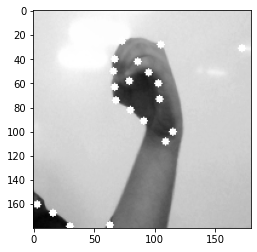

In [16]:
# ภาพตัวอย่างของการสกัด Shi-tomasi
plt.imshow(stms_images[1], 'gray')

In [17]:
# นำ feature Shi-tomasi และ feature hog 
featureTr = np.concatenate((feature_hog, feature_shi), axis = 1)

In [18]:
# feature ที่ได้หลังจากการ concat
featureTr

array([[4.18313793e-02, 3.48518191e-02, 5.60847849e-02, ...,
        2.28000000e+02, 2.27000000e+02, 2.29000000e+02],
       [2.49766428e-01, 7.76706765e-02, 1.59542743e-01, ...,
        1.82000000e+02, 1.83000000e+02, 1.85000000e+02],
       [2.52531377e-01, 9.04700875e-02, 2.52531377e-01, ...,
        2.01000000e+02, 2.00000000e+02, 1.97000000e+02],
       ...,
       [2.40885965e-01, 5.34302148e-02, 2.45442264e-01, ...,
        1.65000000e+02, 1.63000000e+02, 1.64000000e+02],
       [2.69312863e-01, 9.95095965e-02, 2.69312863e-01, ...,
        1.49000000e+02, 1.49000000e+02, 1.49000000e+02],
       [3.95086712e-01, 3.95086712e-01, 2.99216944e-01, ...,
        1.70000000e+02, 1.69000000e+02, 1.68000000e+02]])

In [19]:
# แบ่งข้อมูลเป็นชุด training และ testing
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split

# แบ่งข้อมูลมา train 80% และ test 20% และตั้ง random_state ไว้ เพื่อให้ข้อมูลที่แบ่งไปนั้นเหมือนเดิม ในการรันใหม่ครั้งถัดไป
train,test = train_test_split(img_paths, test_size=0.2, random_state=42)

# save file train และ test เพื่อจะได้ดูว่า รูปใดบ้างที่ถูกไป train และ test
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [21]:
# แบ่ง x_train, x_test, y_train, y_test จาก feature หลัง concat และ label โดยแบ่ง train 80% และ test 20%
# และตั้ง random_state ไว้ เพื่อให้ข้อมูลที่แบ่งไปนั้นเหมือนเดิม ในการรันใหม่ครั้งถัดไป

x_train , x_test , y_train , y_test = train_test_split(featureTr ,
                                                       labelTr, 
                                                       test_size=0.2 , 
                                                       random_state=42)

In [24]:
# import คำสั่งสำหรับ Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier


# จำนวน tree ใน RF จำนวน tree ที่มากขึ้น จะทำให้ performance ดีขึ้นจนถึงจุดนึงที่ performance เริ่มจะนิ่ง จนจำนวน tree ไม่มีผลต่อ performance แล้ว 
# จำนวน tree ที่แนะนำ ตอนเทส model คร่าวๆ ก็ใช้ค่าน้อยๆ ก่อน (50–100 tree) ส่วนตอนที่จำ train จริงจังแล้วก็ใช้ค่า 1000 tree ขึ้นไป
# แต่ละต้นจะได้ feature แตกต่างกันไป

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(x_train,y_train)
prediction_rf = rf.predict(x_test)
print(accuracy_score(prediction_rf,y_test))
print(classification_report(y_test, prediction_rf))

0.58
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.83      1.00      0.91         5
           2       0.40      0.40      0.40         5
           3       0.67      1.00      0.80         2
           4       0.86      0.86      0.86         7
           5       0.33      0.33      0.33         3
           6       0.20      0.50      0.29         2
           7       0.80      0.44      0.57         9
           8       0.33      0.33      0.33         6
           9       0.25      0.33      0.29         3

    accuracy                           0.58        50
   macro avg       0.55      0.58      0.55        50
weighted avg       0.63      0.58      0.59        50



In [25]:
# ข้อมูลจริง
print("The predicted Data is :")
print(np.array(prediction_rf))

The predicted Data is :
[5 0 3 6 4 5 7 6 0 4 7 8 8 2 6 2 4 9 7 0 9 1 4 2 7 1 2 8 1 4 8 1 0 9 1 4 0
 8 3 6 5 3 4 7 2 0 6 9 8 1]


In [26]:
# ข้อมูลที่โมเดลทำนาย
print("The actual data is:")
print(np.array(y_test))

The actual data is:
[5 0 3 2 4 7 7 7 0 4 8 8 9 9 2 8 7 0 7 0 9 0 4 2 7 1 2 0 1 4 8 1 5 8 1 4 0
 7 7 6 4 3 4 7 8 0 5 2 6 1]


In [27]:
# เปรียบเทียบข้อมูลจริงกับโมเดลทำนาย โดยทำออกมาในรูปแบบ dataframe เพื่อจะได้เปรียบเทียบได้อย่างชัดเจน
df=pd.DataFrame({'Actual':y_test, 'Predicted':prediction_rf})
df

,Actual,Predicted
0,5,5
1,0,0
2,3,3
3,2,6
4,4,4
5,7,5
6,7,7
7,7,6
8,0,0
9,4,4
